In [9]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader


from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [10]:
def train_image_model(
    train_dir,
    test_dir,
    checkpoint_path,
    epochs=15,
    batch_size=32,
    lr=1e-4
):
    
    train_tfms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    test_tfms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    
    train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
    test_ds = datasets.ImageFolder(test_dir, transform=test_tfms)
    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, num_workers=4
    )
    test_loader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False, num_workers=4
    )

    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, len(train_ds.classes))
    model = model.to(device)

    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * xb.size(0)
            running_corrects += (preds == yb).sum().item()

        epoch_loss = running_loss / len(train_ds)
        epoch_acc = running_corrects / len(train_ds)
        print(f"Epoch {epoch+1}/{epochs} — Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            preds = outputs.argmax(dim=1)

            test_loss += loss.item() * xb.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    
    test_loss = test_loss / len(test_ds)
    test_acc = sum([p == t for p, t in zip(all_preds, all_labels)]) / len(all_labels)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)

    
    print(f"Test — Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.classes)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
    ax.set_title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Saved image model to {checkpoint_path}")

Epoch 1/15 — Loss: 1.8731, Accuracy: 0.4391
Epoch 2/15 — Loss: 1.0600, Accuracy: 0.6767
Epoch 3/15 — Loss: 0.6549, Accuracy: 0.8008
Epoch 4/15 — Loss: 0.4096, Accuracy: 0.8788
Epoch 5/15 — Loss: 0.2580, Accuracy: 0.9252
Epoch 6/15 — Loss: 0.1833, Accuracy: 0.9470
Epoch 7/15 — Loss: 0.1515, Accuracy: 0.9542
Epoch 8/15 — Loss: 0.1203, Accuracy: 0.9647
Epoch 9/15 — Loss: 0.1003, Accuracy: 0.9693
Epoch 10/15 — Loss: 0.0873, Accuracy: 0.9746
Epoch 11/15 — Loss: 0.0949, Accuracy: 0.9691
Epoch 12/15 — Loss: 0.0759, Accuracy: 0.9769
Epoch 13/15 — Loss: 0.0944, Accuracy: 0.9708
Epoch 14/15 — Loss: 0.0755, Accuracy: 0.9754
Epoch 15/15 — Loss: 0.0730, Accuracy: 0.9783
Test — Loss: 1.1693, Accuracy: 0.7497
Precision: 0.7591
Recall:    0.7497
F1-score:  0.7508
Cohen's Kappa: 0.7347


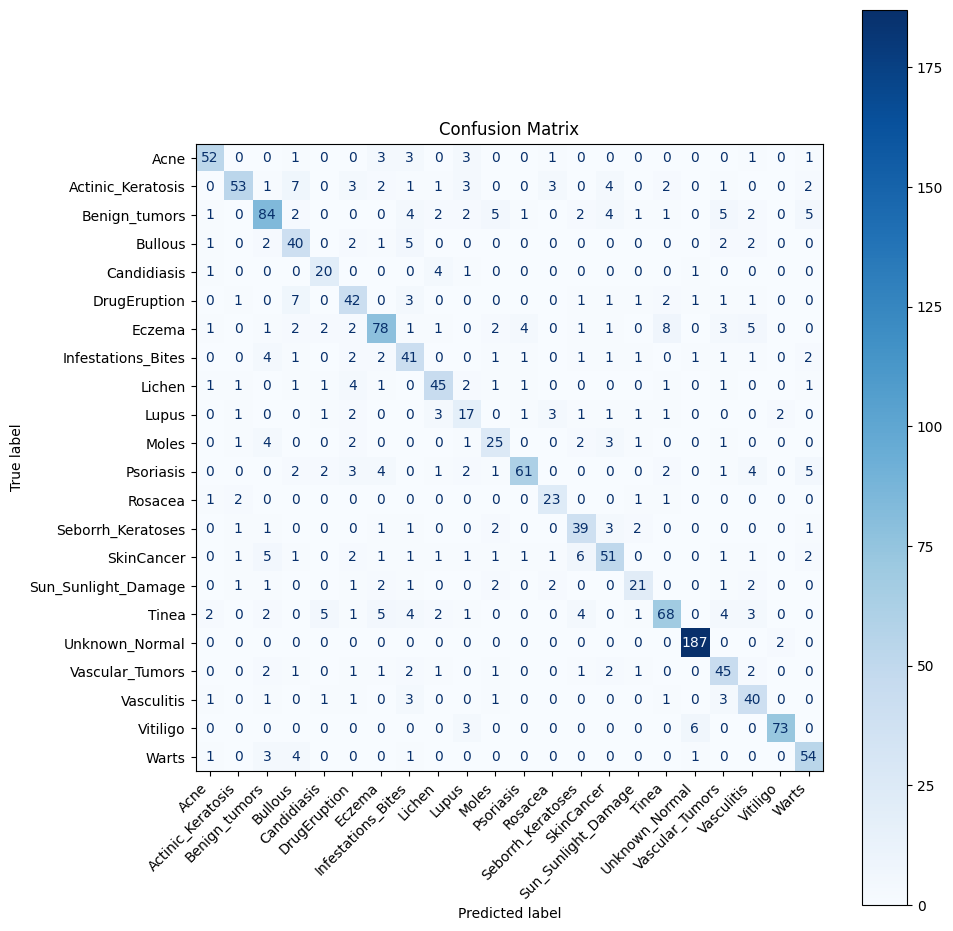

Saved image model to C:/Users/trafl/Desktop/Minor/Model/image_model.pth


In [ ]:
if __name__ == "__main__":
    
    base_dir = r"Dataset/Img-based/SkinDisease"
    train_dir = os.path.join(base_dir, 'Train')
    test_dir = os.path.join(base_dir, 'Test')
    ckpt_path = r"image_model.pth"

    train_image_model(train_dir, test_dir, ckpt_path)